# Regression Project - Zillow

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import wrangle as w
import explore as ex
import evaluate as ev
from pydataset import data
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

## Acquire / Prepare
#### Goals
- acquire the data 
- review and decide how I will deal with nulls and duplicate values
- plan next steps to take

In [3]:
# getting data using function

df = w.get_zillow_data()

In [4]:
# looking at the data

df.head()

,parcel_id,tax_value,bathrooms,bedrooms,calculated_finished_sqft,has_pool,garage_car_count,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,NaN,NaN,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,1.0,NaN,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,NaN,NaN,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,NaN,2.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,NaN,NaN,6037.0,1399.27,2017-08-23


In [5]:
# see how many rows and columns there are

df.shape

(28411, 10)

In [6]:
# checking to see if any data types need to be changed
# checking for nulls
# need to change date to a datetime object 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28411 entries, 0 to 28410
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   parcel_id                 28411 non-null  int64  
 1   tax_value                 28410 non-null  float64
 2   bathrooms                 28411 non-null  float64
 3   bedrooms                  28411 non-null  float64
 4   calculated_finished_sqft  28338 non-null  float64
 5   has_pool                  6132 non-null   float64
 6   garage_car_count          10170 non-null  float64
 7   fips                      28411 non-null  float64
 8   tax_amount                28410 non-null  float64
 9   transaction_date          28411 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.2+ MB


In [8]:
df.tax_value.sort_values()

21084        1000.0
16079        7771.0
5907        10504.0
14696       11089.0
10029       11683.0
            ...    
3958     15623925.0
5905     18812604.0
9717     22589311.0
3515     23858374.0
21388           NaN
Name: tax_value, Length: 28411, dtype: float64

In [9]:
# change transaction_date to datetime object
# line is in wrangle.py

df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [10]:
df.duplicated().value_counts()

False    28411
dtype: int64

In [11]:
# See if there are any null values

w.missing_values_table(df)

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
has_pool,22279,78.4
garage_car_count,18241,64.2
calculated_finished_sqft,73,0.3
tax_value,1,0.0
tax_amount,1,0.0


#### Takeaways Nulls / Dupes
- There are no duplicate rows! 
- Missing values in pool and garage car count will be filled with 0
- Garage car count will be changed to new boolian variable has_garage
    - anything over 1 will be changed to 1 any 0s or NaNs will be 0s
- Not too many missing values. Will drop rows with missing values after cleaning pool and garage variables
    - 73 sqft missing - DROP
    - 1 tax_value - DROP
    - 1 tax_amount DROP 

In [12]:
# fill nans with 0s

df['has_pool'] = df.has_pool.fillna(value=0)

In [13]:
# fill nas with 0s for garage

df.garage_car_count.fillna(value=0, inplace=True)

# add new column has garage as boolian. anything over 1 is having a garage, 0 no garage

df['has_garage'] = (df.garage_car_count != 0).astype(int)

In [14]:
# drop the rows with NaNs

df.drop(df[df.isna().any(axis=1)].index, inplace=True)

In [15]:
# look at unique values in each column

for col in df.drop(columns=['parcel_id', 'tax_value', 'tax_amount']).columns:
    print(f'---------------')
    print(f'There are {df[col].nunique()} unique values in the {col} column')

---------------
There are 20 unique values in the bathrooms column
---------------
There are 13 unique values in the bedrooms column
---------------
There are 4056 unique values in the calculated_finished_sqft column
---------------
There are 2 unique values in the has_pool column
---------------
There are 14 unique values in the garage_car_count column
---------------
There are 3 unique values in the fips column
---------------
There are 120 unique values in the transaction_date column
---------------
There are 2 unique values in the has_garage column


#### Will keep the 1 bathroom and 0 bedrooms with sqft - possible studio

#### Zero's in  bedrooms and bathrooms with sqft will be dropped

In [16]:
total_rows = df.shape[0] 
rows_with =  df[df.bathrooms == 0].shape[0]

print(f'There are {total_rows} total rows, {rows_with} with 0 in the bathroom column.')
print(f'If we drop these rows there should be {total_rows-rows_with} rows left')
print(f'It\'s {rows_with/total_rows:.2%} of the data')

There are 28336 total rows, 35 with 0 in the bathroom column.
If we drop these rows there should be 28301 rows left
It's 0.12% of the data


In [17]:
# drop the rows with the 0 bathroom count

df.drop(df[df.bathrooms == 0].index, inplace=True)

# check shape

df.shape

(28301, 11)

## County and Tax Rates
#### Goals
- switch fips to county names
- calculate tax rate (tax amt/tax value)
- vizualize

In [18]:
# this shows all the counties id's

df.fips.unique()

array([6037., 6059., 6111.])

In [19]:
# make dictionary with fips values and county names

counties = {6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'}

# use .replace to create an new column called county

df['county'] = df.fips.replace(counties)

In [20]:
# number of homes per county

df['county'].value_counts()

Los Angeles    17909
Orange          7740
Ventura         2652
Name: county, dtype: int64

In [22]:
# create new column with tax_rate

df['tax_rate'] = df.tax_amount / df.tax_value

In [101]:
# tax rate per county

df.groupby('fips').tax_rate.mean()

fips
6037.0    0.014124
6059.0    0.012084
6111.0    0.011791
Name: tax_rate, dtype: float64

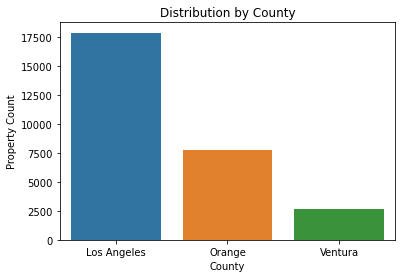

In [24]:
plt.title('Distribution by County')
sns.countplot(df.county)
plt.xlabel('County')
plt.ylabel('Property Count')
plt.show()

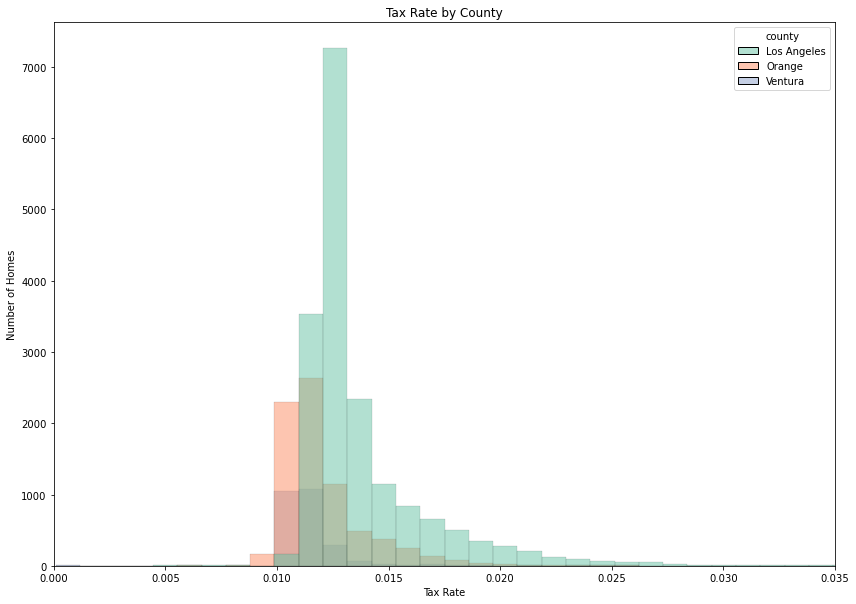

In [25]:
# plot tax rate by county

plt.figure(figsize=(14,10))
sns.histplot(data=df, x="tax_rate", hue="county", kde = False, bins = 750, palette = "Set2")

plt.title('Tax Rate by County')
plt.ylabel('Number of Homes')
plt.xlabel('Tax Rate')
plt.xlim(0, 0.035)
plt.show()

### Target
- tax_value

### Variables 
#### Categorial variables:
- fips
- bedrooms
- bathrooms 

#### EXTRA features
- has_pool
- has_garage

#### Continous variables:
- calculated_finished_sqft
- transaction_date 

#### Other
- parcel_id - unique identifer
- tax_amount - not used for modeling

## Explore 
#### Goals 
- Univariate exploration 
    - find and deal with outliers
- train, validate, test split
- Multivariate exploration
- Vizualize relationship between variables and target
- Find Drivers
- State Hypotheses and run some Statistical Tests


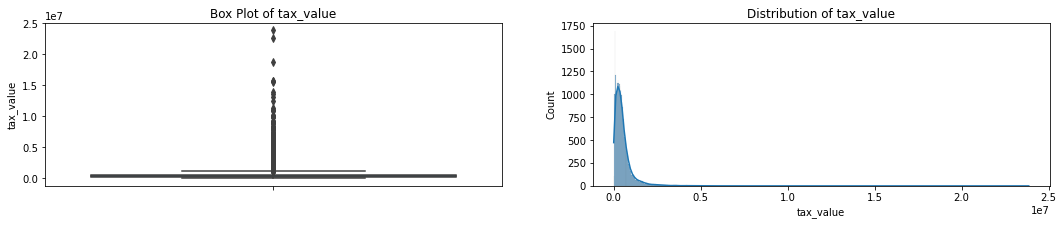

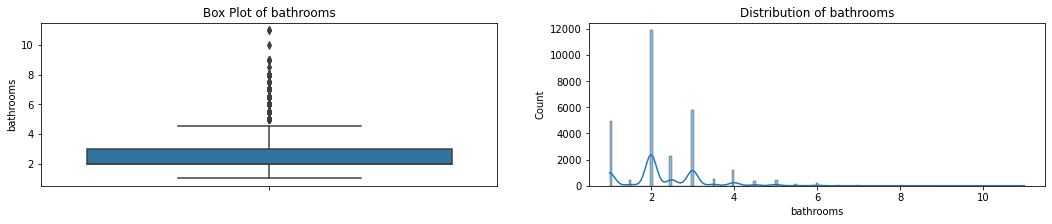

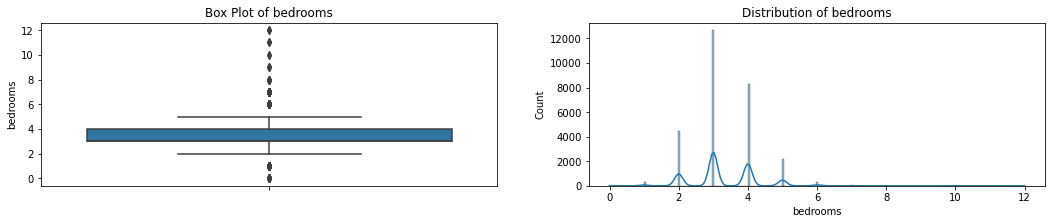

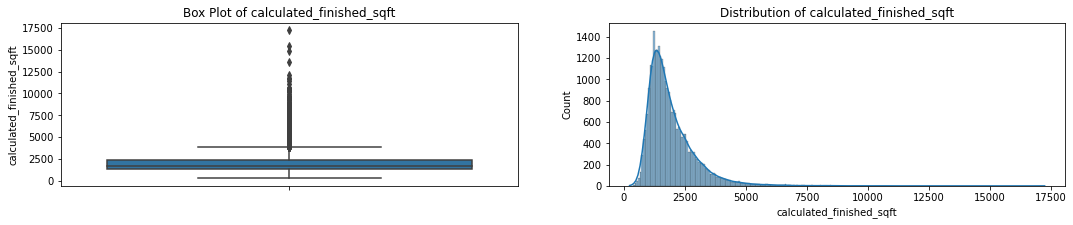

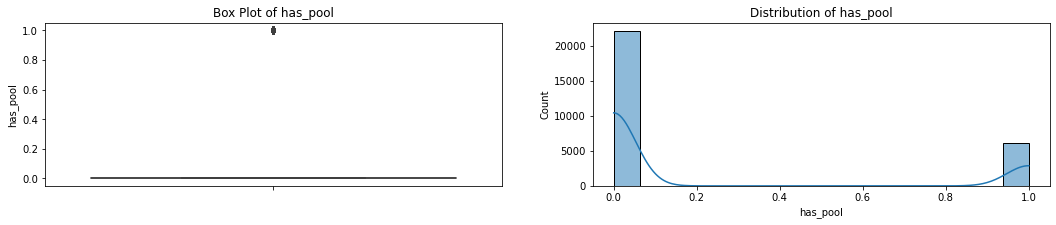

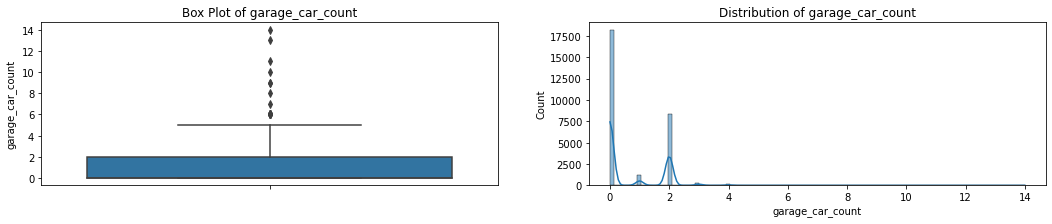

In [26]:
# use function from explore to look at distributions

ex.explore_univariate(df[['tax_value', 'bathrooms', 'bedrooms', 'calculated_finished_sqft', 'has_pool', 'garage_car_count']])

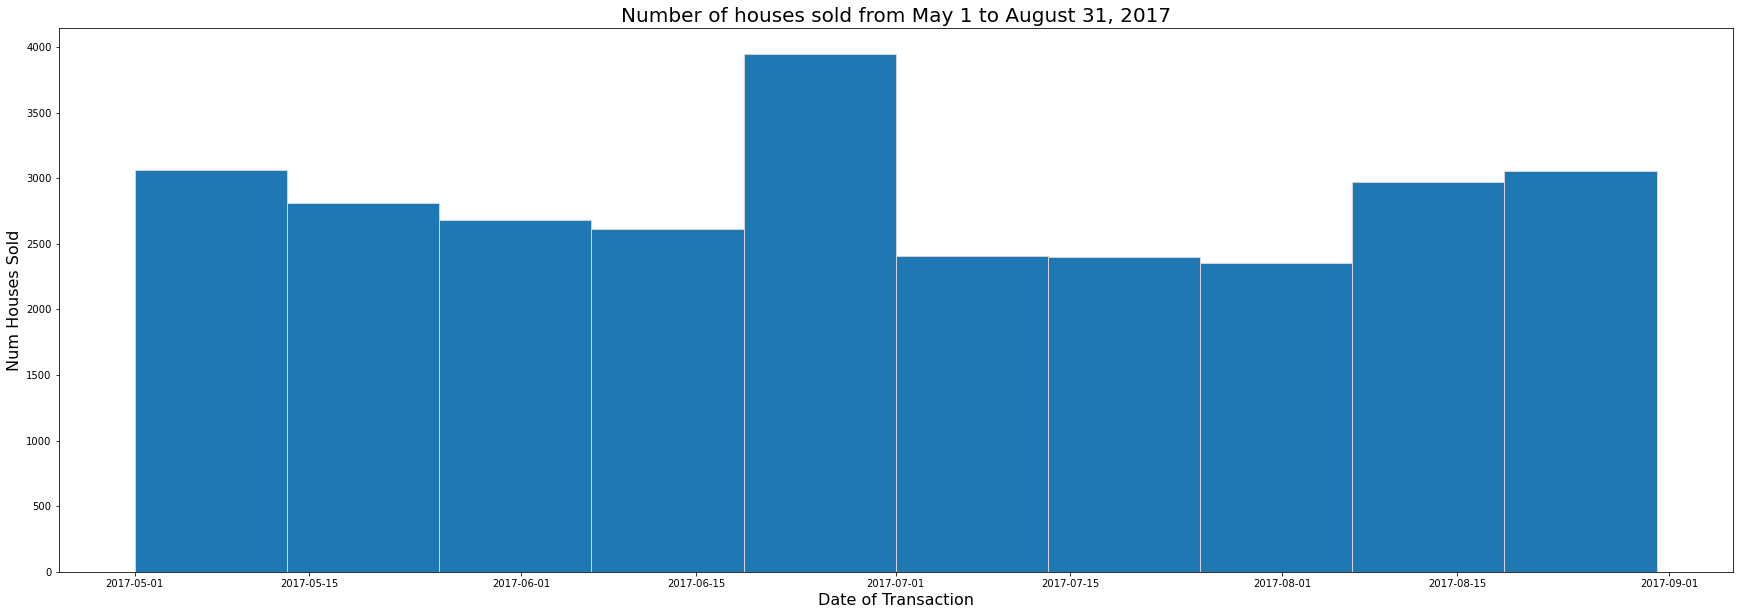

In [27]:
# plot dates houses were sold

plt.figure(figsize=(30, 10))
plt.hist(df.transaction_date, lw = 1, ec = 'lightgrey')
plt.xlabel('Date of Transaction', fontsize = 16)
plt.ylabel('Num Houses Sold', fontsize = 16)
plt.title('Number of houses sold from May 1 to August 31, 2017', fontsize = 20)
plt.show()

### Takeaways
- Need to drop outliers
    - drop outliers in bedrooms, bathrooms, and calculated_finished_sqft with absolute value z_score above 3
    - done in wrangle file
- most of the houses are in LA county (fips 6037)
- The second half of June 2017 seen highest number of house sales

### Train, Validate, Test Split and Bivarate Exploration

In [28]:
# get the prepared data

df = w.wrangle_zillow()

In [29]:
train, validate, test = w.banana_split(df)

train --> (15484, 12)
validate --> (6637, 12)
test --> (5531, 12)


In [30]:
train.columns

Index(['parcel_id', 'tax_value', 'bathrooms', 'bedrooms',
       'calculated_finished_sqft', 'has_pool', 'fips', 'tax_amount',
       'transaction_date', 'has_garage', 'county', 'tax_rate'],
      dtype='object')

In [31]:
# drop the columns not needed for exploration

train_ex = train.drop(columns=['parcel_id', 'fips', 'tax_amount', 'transaction_date'])

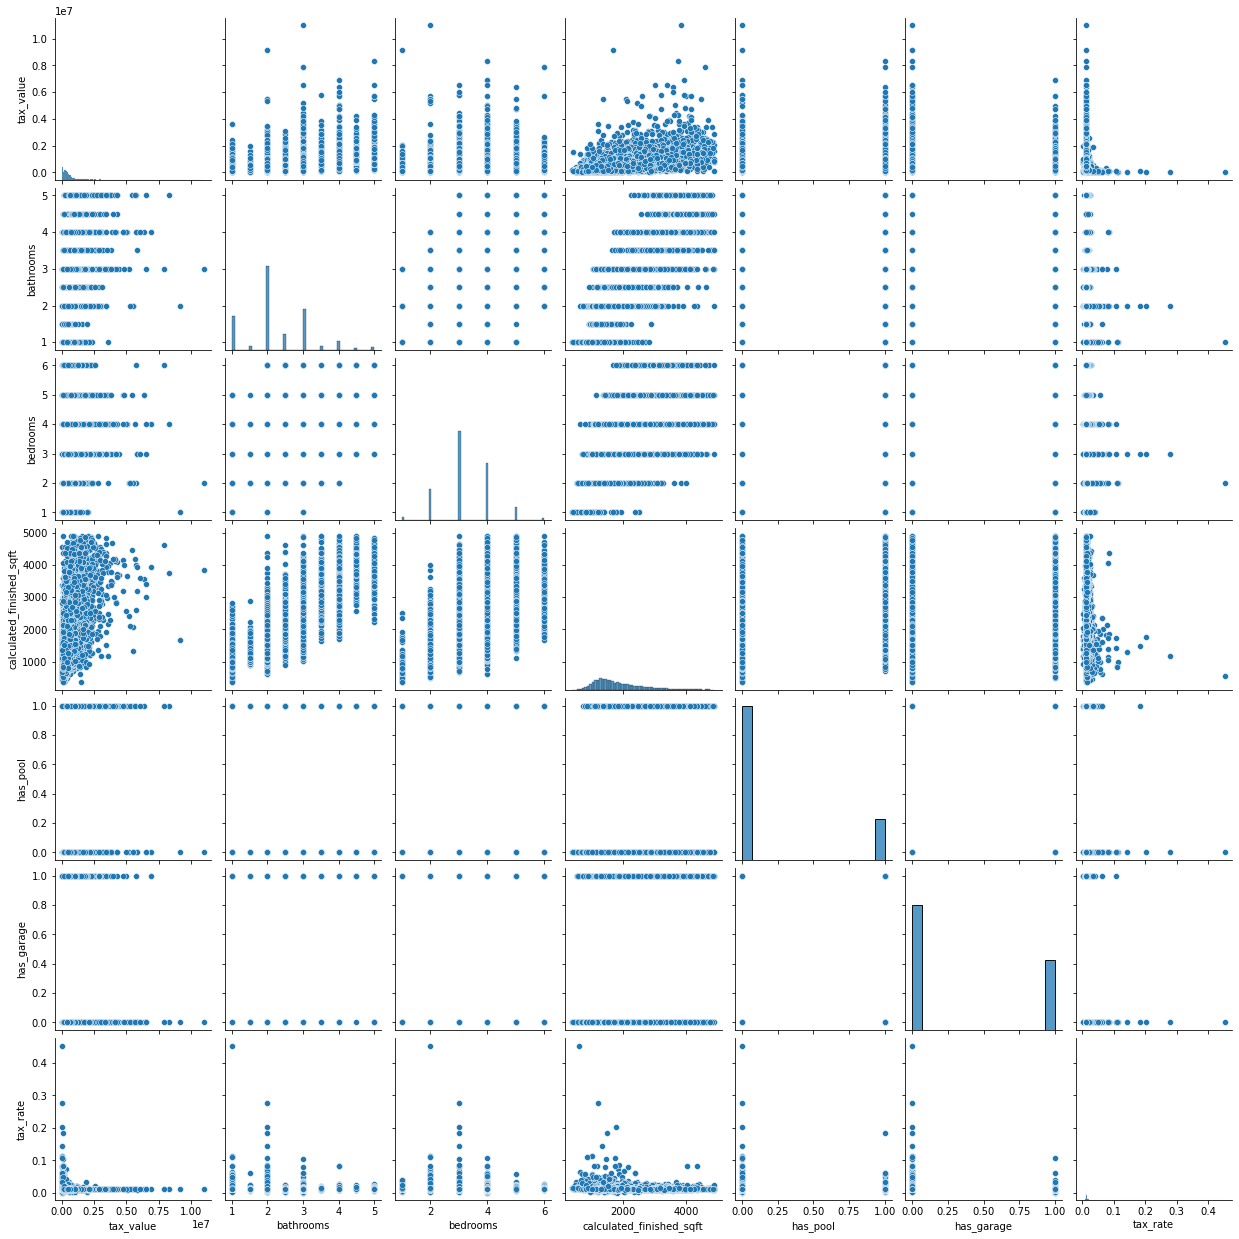

In [32]:
sns.pairplot(train_ex)

#### Takeaways
- As the house get larger, the cost increases
- Largers homes typically have more bedrooms and more bathrooms

In [33]:
# use minmax scaler on sqft_calculated 

scaler, scaled_cols = w.my_scaler(train, validate, test, ['calculated_finished_sqft'], MinMaxScaler(), 'minmax')

Your scaled columns have been added to your train validate and test dataframes.


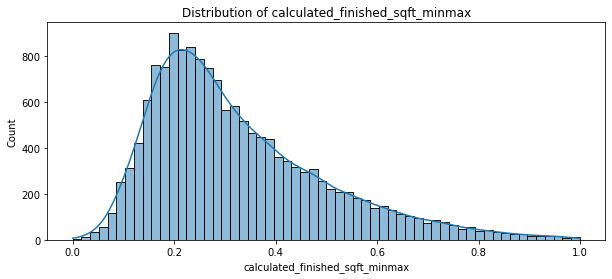

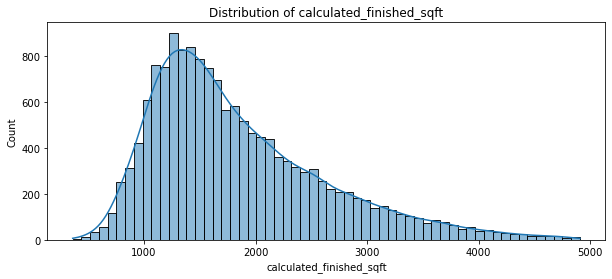

In [34]:
# vizualize sclaed data vs original data

ex.plot_variable_dist(train[['calculated_finished_sqft_minmax', 'calculated_finished_sqft']], figsize = (10,4))

<AxesSubplot:>

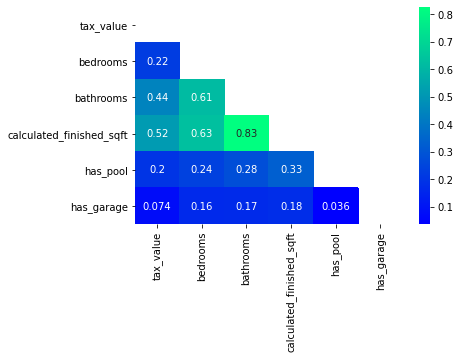

In [35]:
correlation = train[['tax_value', 'bedrooms', 'bathrooms', 'calculated_finished_sqft', 'has_pool', 'has_garage']].corr()
sns.heatmap(correlation, cmap='winter', annot = True, mask = np.triu(correlation))

#### Takeaways
- bedrooms, bathrooms, and calculated finished sqft have the highest corelation with tax_value

## Hypothesis Testing

- Alpha = 0.05
- Confidence interval = 0.95

In [36]:
# number of samples

n = test.shape[0]

# degrees of freedom

deg_f = n-2

# confidence interval

conf_in = 0.95
alpha = 0.05

n, deg_f, conf_in, alpha

(5531, 5529, 0.95, 0.05)

### Hypothesis 1
- Test: Pearson R

Ho: There is no linear correlation  between total square footage and tax value

Ha: There is a linear correlation between total square footage and tax value 

In [37]:
corr, p = stats.pearsonr(train.calculated_finished_sqft_minmax, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.517
p value is 0.0
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


### Hypothesis 2
- Test: Pearson R

Ho: There is no linear correlation between number of bathrooms and tax value (home value) 

Ha: There is a linear correlation between number of bathrooms and tax value (home value)

In [38]:
corr, p = stats.pearsonr(train.bathrooms, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4428
p value is 0.0
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


## Modeling
#### Goals
- Establish and create a basline
    - Evaluate the basline
- Create at least 2 models (GLM) and try to beat the baseline metrics

#### GLM
- The target resembles a gamma distribution
- Start with power = 2: Gamma Distribution, then will try with power 1

#### Variables
- First tries are with bathrooms (not scaled), bedrooms (not scaled) and scalculated_finished_sqft_minmax (scaled)
    - variable set 1
- Second tries are with bathrooms__minmax (scaled), bedrooms__minmax (scaled) calculated_finished_sqft_minmax (scaled), and has_pool (not scaled)
    - variable set 2

### Baseline
- mean and median, see which one is better

In [39]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathrooms', 'bedrooms', 'calculated_finished_sqft_minmax']]

y_validate = validate.tax_value
X_validate = validate[['bathrooms', 'bedrooms', 'calculated_finished_sqft_minmax']]

y_test = test.tax_value
X_test = test[['bathrooms', 'bedrooms', 'calculated_finished_sqft_minmax']]

In [40]:
# add predictions to dataframes

train['baseline_mean'] = train.tax_value.mean()
train['baseline_median'] = train.tax_value.median()

validate['baseline_mean'] = train.tax_value.mean()
validate['baseline_median'] = train.tax_value.median()

test['baseline_mean'] = train.tax_value.mean()
test['baseline_median'] = train.tax_value.median()

In [41]:
# set up baseline and look at rmse

ev.compare_rmse([(train.baseline_mean, y_train), (validate.baseline_mean, y_validate), (train.baseline_median, y_train), (validate.baseline_median, y_validate) ])

RMSE for baseline_mean: 494508.908394784 
RMSE for baseline_mean: 483733.4021585655 
RMSE for baseline_median: 506744.9837787276 
RMSE for baseline_median: 495751.3376150452 


#### Takeaways
- baseline mean is slightly better than median
- rmse to beat is 494,508.90

In [42]:
# Select K Best model

ev.select_kbest(X_train, y_train, 2)

['bathrooms', 'calculated_finished_sqft_minmax']

In [43]:
# RFE (Recursive Feature Elimination)

ev.rfe(X_train, y_train, 2)

['bedrooms', 'calculated_finished_sqft_minmax']

### Tweedie Regressor (GLM) Model 1
- power 2
- variable set 1

In [44]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train dataframe
train['glm1'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm1'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm1, y_train), (validate.glm1, y_validate)])

RMSE for glm1: 415258.2734279887 
RMSE for glm1: 407442.24586481624 


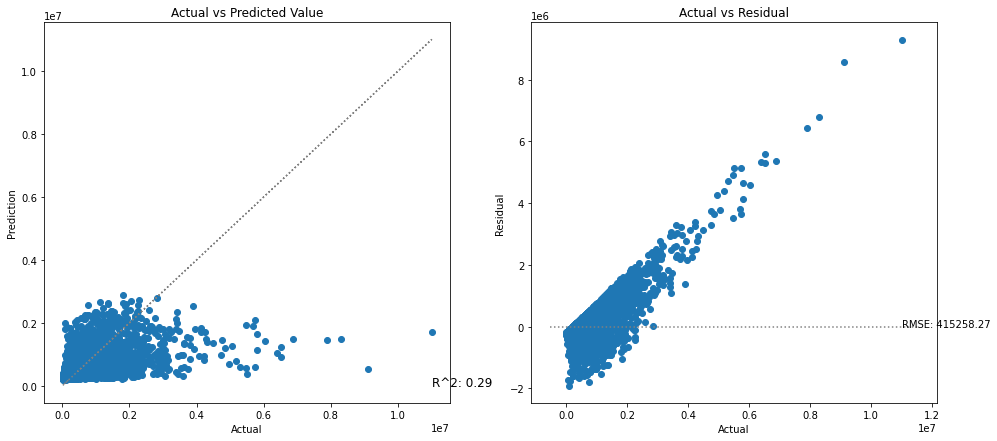

In [45]:
ev.plot_the_dots(y_train, train.glm1, y_train - train.glm1)

### Tweedie Regressor (GLM) Model 2

In [46]:
glm = TweedieRegressor(power=1, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train dataframe
train['glm2'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm2'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm2, y_train), (validate.glm2, y_validate)])

RMSE for glm2: 413950.0589451053 
RMSE for glm2: 405134.4857686174 


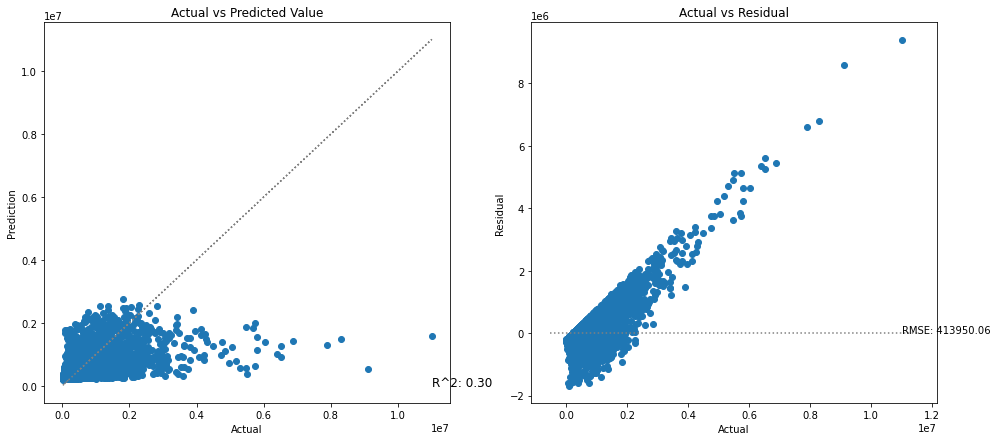

In [47]:
ev.plot_the_dots(y_train, train.glm2, y_train - train.glm2)

### LassoLars Model 1
- alpha 1
- variable set 1

In [48]:
lars = LassoLars(alpha=1.0)

# fit model
lars.fit(X_train, y_train)

# put predictions in train dataframe
train['lars1'] = lars.predict(X_train)

# put predictions in validate dataframe
validate['lars1'] = lars.predict(X_validate)

ev.compare_rmse([(train.lars1, y_train), (validate.lars1, y_validate)])

RMSE for lars1: 417251.07844314305 
RMSE for lars1: 406707.3720588334 


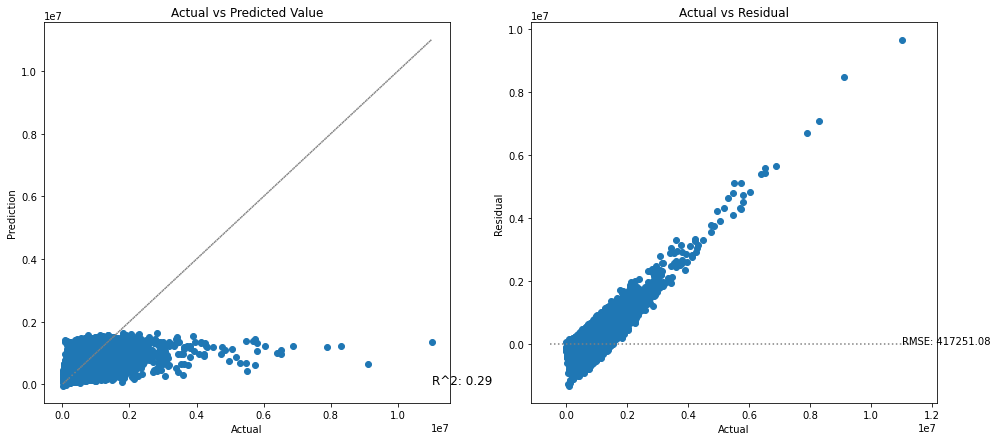

In [49]:
ev.plot_the_dots(y_train, train.lars1, y_train - train.lars1)

In [50]:
col_names = ['bathrooms', 'bedrooms', 'calculated_finished_sqft']

MM_scaler, scaled_cols = w.my_scaler(train, validate, test, col_names, MinMaxScaler(), 'minmax')

Your scaled columns have been added to your train validate and test dataframes.


In [51]:
# establish X and y

y_train = train.tax_value
X_train = train[['bathrooms_minmax', 'bedrooms_minmax', 'calculated_finished_sqft_minmax', 'has_pool']]

y_validate = validate.tax_value
X_validate = validate[['bathrooms_minmax', 'bedrooms_minmax', 'calculated_finished_sqft_minmax', 'has_pool']]

y_test = test.tax_value
X_test = test[['bathrooms_minmax', 'bedrooms_minmax', 'calculated_finished_sqft_minmax', 'has_pool']]

In [52]:
# Select K Best model

ev.select_kbest(X_train, y_train, 3)

['bathrooms_minmax', 'bedrooms_minmax', 'calculated_finished_sqft_minmax']

In [53]:
# RFE (Recursive Feature Elimination)

ev.rfe(X_train, y_train, 4)

['bathrooms_minmax',
 'bedrooms_minmax',
 'calculated_finished_sqft_minmax',
 'has_pool']

### Tweedie Regressor (GLM) Model 3
- GLM power 2
- variable set 2

In [54]:
glm = TweedieRegressor(power=2, alpha=0)

# fit model

glm.fit(X_train, y_train)

# put predictions in train  dataframe

train['glm3'] = glm.predict(X_train)

# put predictions in validate dataframe

validate['glm3'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm3, y_train), (validate.glm3, y_validate)])

RMSE for glm3: 414955.4123006496 
RMSE for glm3: 407150.04133410566 


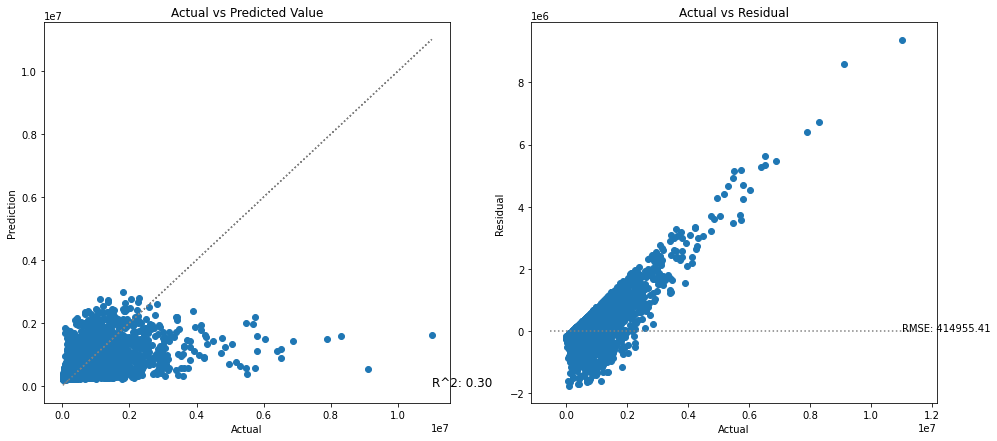

In [55]:
ev.plot_the_dots(y_train, train.glm3, y_train - train.glm3)

### Tweedie Regressor (GLM) Model 4
- GLM power 1
- Variable set 2

In [56]:
glm = TweedieRegressor(power=1, alpha=0)

# fit model

glm.fit(X_train, y_train)

# put predictions in train dataframe

train['glm4'] = glm.predict(X_train)

# put predictions in validate dataframe

validate['glm4'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm4, y_train), (validate.glm4, y_validate)])

RMSE for glm4: 413641.39221583575 
RMSE for glm4: 404838.4652643998 


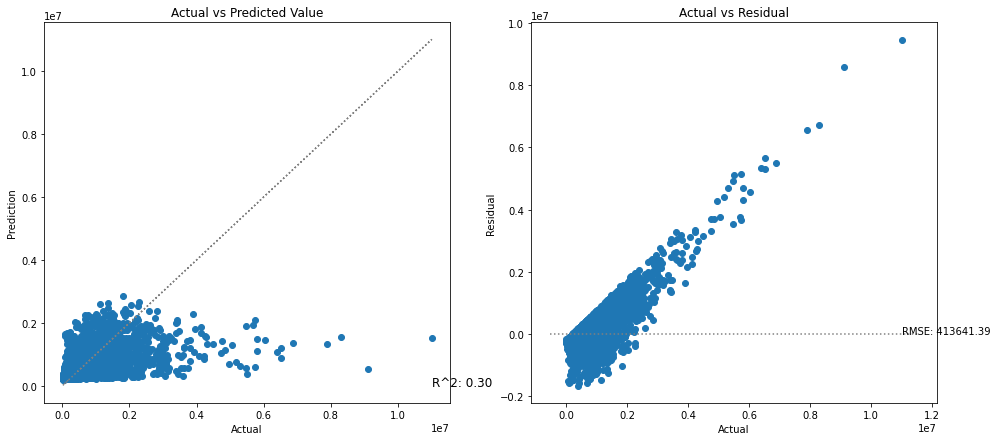

In [57]:
ev.plot_the_dots(y_train, train.glm4, y_train - train.glm4)

In [58]:
model_list = ['glm1', 'glm2', 'glm3', 'glm4', 'lars1']

for model in model_list:
    ev.compare_rmse([(train[model], y_train), (validate[model], y_validate)])

RMSE for glm1: 415258.2734279887 
RMSE for glm1: 407442.24586481624 
RMSE for glm2: 413950.0589451053 
RMSE for glm2: 405134.4857686174 
RMSE for glm3: 414955.4123006496 
RMSE for glm3: 407150.04133410566 
RMSE for glm4: 413641.39221583575 
RMSE for glm4: 404838.4652643998 
RMSE for lars1: 417251.07844314305 
RMSE for lars1: 406707.3720588334 


### Takeaways Models
- Model glm4 performed the best
- Train RMSE for glm4: 413641.39
- Validate RMSE for glm4: 404838.46
- Pretty close together not overfit
- From the graph below can see that the top 3 performing models do very close to the same on the validate set
- We're going to go forward with glm4

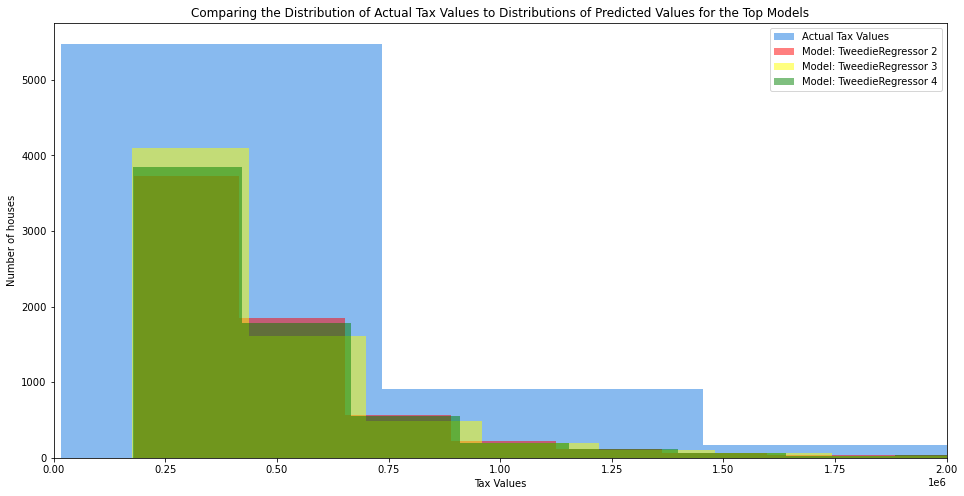

In [59]:
plt.figure(figsize=(16,8))
plt.hist(validate.tax_value, color='#1277e1', alpha=.5, label="Actual Tax Values")
plt.hist(validate.glm2, color='red', alpha=.5, label="Model: TweedieRegressor 2")
plt.hist(validate.glm3, color='yellow', alpha=.5, label="Model: TweedieRegressor 3")
plt.hist(validate.glm4,color='green', alpha=.5, label="Model: TweedieRegressor 4")
plt.xlim((0,2000000))
plt.xlabel("Tax Values")
plt.ylabel("Number of houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

### Tweedie Regressor (GLM) Model 4 Test

In [60]:
glm = TweedieRegressor(power=1, alpha=0)

# fit model

glm.fit(X_train, y_train)

# put predictions in test dataframe

test['glm4'] = glm.predict(X_test)

ev.compare_rmse([(test.glm4, y_test)])

RMSE for glm4: 470773.00519557536 


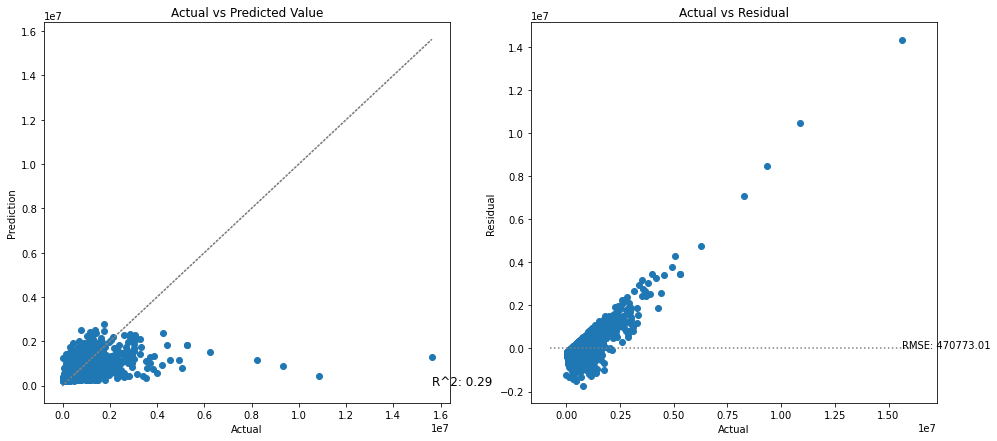

In [61]:
ev.plot_the_dots(y_test, test.glm4, y_test-test.glm4)

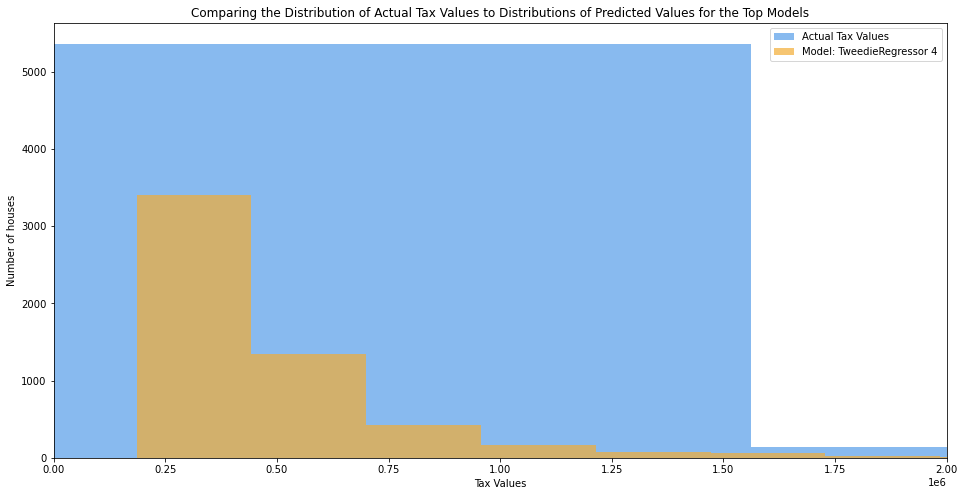

In [62]:
plt.figure(figsize=(16,8))
plt.hist(test.tax_value, color='#1277e1', alpha=.5, label="Actual Tax Values")
plt.hist(test.glm4,color='#f3ad35', alpha=.7, label="Model: TweedieRegressor 4")
plt.xlim((0,2000000))
plt.xlabel("Tax Values")
plt.ylabel("Number of houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

In [104]:
b_rmse = mean_squared_error(y_test, test.baseline_mean, squared=False)
glm4_rmse = mean_squared_error(y_test, test.glm4, squared=False)

percent_improve =  (b_rmse - glm4_rmse) / b_rmse

print(f'Model Performs {percent_improve:.1%} better than the baseline')

Model Performs 15.5% better than the baseline


### Takeaways 
- model GLM4 did well on the test set
- RMSE 470773.00
- I believe a factor that the RMSE is lower because there are not as many datapoints

## Conclusion 

- Using the variables, number of bedrooms, number of bathrooms, square footage, and has a pool, was able to create a model that performs 15.5% better than the baseilne
- From Hypothesis testing suggested a linear relationship between number of bathrooms and home value, as well as between square footage and home value

#### For Future Exploration
- Research other ways to handle outliers, nulls, ways to improve model performance
- Look into using more  features such as the home age, zip code, latitude/longitude, ect. 
